C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14063490978424847 and num_layers=1
  warnings.warn(


Epoch 1/50, Train Loss: 0.0033, Validation Loss: 0.0009
Epoch 2/50, Train Loss: 0.0002, Validation Loss: 0.0006
Epoch 3/50, Train Loss: 0.0001, Validation Loss: 0.0002
Epoch 4/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 5/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 6/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 7/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 8/50, Train Loss: 0.0001, Validation Loss: 0.0002
Epoch 9/50, Train Loss: 0.0001, Validation Loss: 0.0000
Epoch 10/50, Train Loss: 0.0002, Validation Loss: 0.0006
Epoch 11/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 12/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 13/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 14/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 15/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 16/50, Train Loss: 0.0001, Validation Loss: 0.0001
Epoch 17/50, Train Loss: 0.0001, Validation Loss: 0.0004
Epoch 18/50, Train Loss: 0.0001, Validat

C:\Users\User\anaconda3\envs\RL\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 152  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 1280 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.49e+03    |
|    ep_rew_mean          | 0.898       |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004321348 |
|    clip_fraction        | 0.0364      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | -7.36       |
|    learning_rate        | 0.0014      |
|    loss                 | 0.00509     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.005

C:\Users\User\anaconda3\envs\RL\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


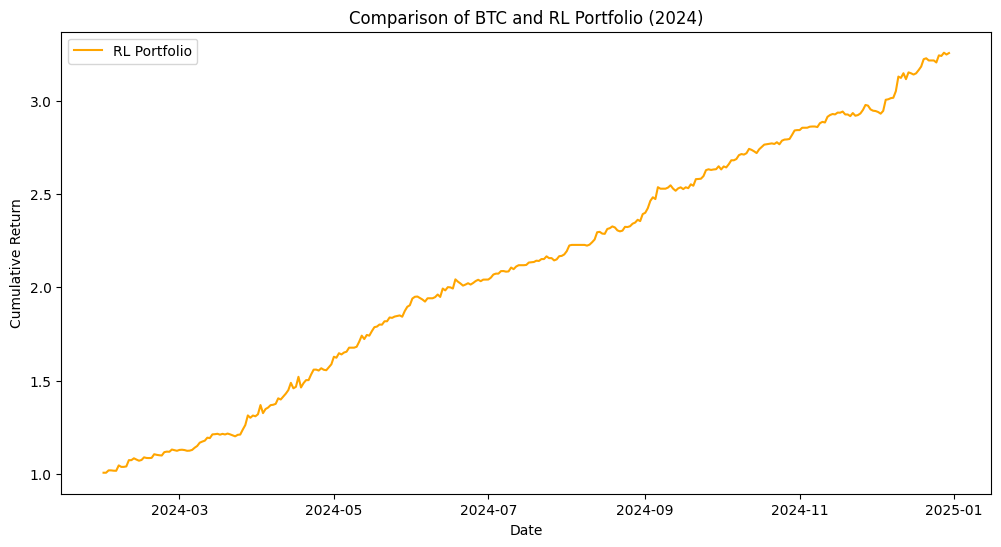

Cumulative Return of PPO Model: 3.2542529726995926
Sharpe Ratio: 0.4235604787617435
Max Drawdown: -0.037502538061158885


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from stable_baselines3 import PPO
from gym import spaces, Env
import matplotlib.pyplot as plt
import random

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Load and preprocess data
data = pd.read_csv("Book1.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values(by="Date")

# Remove non-numeric columns
numeric_data = data.drop(columns=["Date"])

# Move 'Close' column to the first position
numeric_data = numeric_data[['Close'] + [col for col in numeric_data.columns if col != 'Close']]

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(numeric_data)

# Add normalized data back to the original dataframe for splitting by date
data[numeric_data.columns] = normalized_data

# Split data based on years
train_data = data[(data["Date"].dt.year >= 2017) & (data["Date"].dt.year <= 2022)].drop(columns=["Date"]).values
validation_data = data[data["Date"].dt.year == 2023].drop(columns=["Date"]).values
test_data = data[data["Date"].dt.year == 2024].drop(columns=["Date"]).values

# Define the create_sequences function
def create_sequences(data, sequence_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length, 0]  # Assuming the target is the first column (e.g., Close price)
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Convert data to sequences for time series
sequence_length = 30
X_train, y_train = create_sequences(train_data, sequence_length)
X_validation, y_validation = create_sequences(validation_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Define the Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # Predicting a single value (e.g., target price)

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        return self.fc(bilstm_out[:, -1, :])

# Hyperparameters for Bi-LSTM
input_dim = X_train.shape[2]
hidden_dim = 224
num_layers = 1
dropout = 0.14063490978424847
learning_rate = 0.00191084309168345
num_epochs = 50
batch_size = 32

# Prepare data for PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
validation_dataset = TensorDataset(torch.tensor(X_validation, dtype=torch.float32), torch.tensor(y_validation, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the Bi-LSTM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bilstm_model = BiLSTMModel(input_dim, hidden_dim, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=learning_rate)

# Train the Bi-LSTM model
for epoch in range(num_epochs):
    bilstm_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = bilstm_model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validate the model
    bilstm_model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in validation_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            predictions = bilstm_model(X_val).squeeze()
            loss = criterion(predictions, y_val)
            validation_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {validation_loss/len(validation_loader):.4f}")

# Define a custom trading environment for Bi-LSTM
class TradingEnvBiLSTM(Env):
    def __init__(self, data, model, device, sequence_length=30):
        super(TradingEnvBiLSTM, self).__init__()
        self.data = data
        self.model = model
        self.device = device
        self.sequence_length = sequence_length
        self.current_step = 0
        self.total_steps = len(data) - sequence_length
        self.portfolio_value = 1.0

        # Define action and observation spaces
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(sequence_length, data.shape[1] + 1), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.portfolio_value = 1.0
        return self._next_observation()

    def _next_observation(self):
        obs = self.data[self.current_step:self.current_step + self.sequence_length]
        current_sequence = torch.tensor(obs, dtype=torch.float32).to(self.device).unsqueeze(0)
        predicted_price = self.model(current_sequence).item()

        # Add the predicted price to the observation
        obs_with_prediction = np.hstack((obs, np.full((obs.shape[0], 1), predicted_price)))
        return obs_with_prediction

    def step(self, action):
        self.current_step += 1

        # Map continuous actions to discrete
        if action < -0.33:
            discrete_action = 2  # Sell
        elif action > 0.33:
            discrete_action = 1  # Buy
        else:
            discrete_action = 0  # Hold

        reward = 0
        done = self.current_step >= self.total_steps

        # Calculate reward
        if discrete_action == 1:  # Buy
            reward = self.data[self.current_step, 0] - self.data[self.current_step - 1, 0]
        elif discrete_action == 2:  # Sell
            reward = self.data[self.current_step - 1, 0] - self.data[self.current_step, 0]

        # Update portfolio value
        self.portfolio_value += reward

        obs = self._next_observation() if not done else None
        return obs, reward, done, {"portfolio_value": self.portfolio_value}

# Split data for training and testing PPO
train_env_data = data[(data["Date"].dt.year >= 2017) & (data["Date"].dt.year <= 2023)].drop(columns=["Date"]).values
test_env_data = data[data["Date"].dt.year == 2024].drop(columns=["Date"]).values

# Create separate environments for training and testing
train_env = TradingEnvBiLSTM(train_env_data, bilstm_model, device)
test_env = TradingEnvBiLSTM(test_env_data, bilstm_model, device)

# Train the PPO model
ppo_model = PPO("MlpPolicy", train_env, learning_rate=0.001400281687989954, n_steps=1280, batch_size=160, verbose=1, gamma=0.9005911776350177)
ppo_model.learn(total_timesteps=50000)

# Evaluate the PPO model on the test environment
def evaluate_trading_strategy(env, model):
    obs = env.reset()
    done = False
    portfolio_values = [1.0]

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        portfolio_values.append(info.get("portfolio_value", 1.0))

    cumulative_return = portfolio_values[-1] - portfolio_values[0]
    return cumulative_return, portfolio_values

cumulative_return, portfolio_values = evaluate_trading_strategy(test_env, ppo_model)

# Calculate portfolio cumulative return using cumprod
portfolio_daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
portfolio_cumulative_return = np.cumprod(1 + portfolio_daily_returns)

# Final cumulative return based on cumprod
final_cumulative_return = portfolio_cumulative_return[-1]

print("Cumulative Return of PPO Model (via cumprod):", final_cumulative_return)

# Compare with BTC Returns
data['BTC_Returns'] = data['Close'].pct_change()
data['BTC_Cumulative_Return'] = (1 + data['BTC_Returns']).cumprod()

# Filter BTC data for 2024
btc_data_2024 = data[data['Date'].dt.year == 2024]

# Align data lengths
dates = btc_data_2024['Date'][sequence_length:sequence_length + len(portfolio_values)]
btc_cumulative_return = btc_data_2024['BTC_Cumulative_Return'][sequence_length:sequence_length + len(portfolio_values)]

if len(dates) > len(portfolio_values):
    dates = dates[:len(portfolio_values)]
elif len(dates) < len(portfolio_values):
    portfolio_values = portfolio_values[:len(dates)]

# Ensure BTC Cumulative Return is aligned
if len(btc_cumulative_return) > len(portfolio_values):
    btc_cumulative_return = btc_cumulative_return[:len(portfolio_values)]

# Plot BTC vs RL Portfolio
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_cumulative_return, label='RL Portfolio', color='orange')
plt.title("Comparison of BTC and RL Portfolio (2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# Calculate additional metrics
sharpe_ratio = np.mean(portfolio_daily_returns) / np.std(portfolio_daily_returns)
max_drawdown = np.min(portfolio_cumulative_return / np.maximum.accumulate(portfolio_cumulative_return) - 1)

print("Cumulative Return of PPO Model:", final_cumulative_return)
print("Sharpe Ratio:", sharpe_ratio)
print("Max Drawdown:", max_drawdown)

